In [1]:
import pandas as pd
from ast import literal_eval
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.compat import lzip
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
converters = {"director": literal_eval, "author": literal_eval, "actor": literal_eval, "genre": literal_eval}
movies = pd.read_csv("./data/movies_actors_df.csv", index_col=0, converters=converters)

In [3]:
# drop irrelevant columns
movies.drop(columns=["url", "image", "datePublished", "duration", "description", "language"], inplace=True, errors="ignore")
movies.head()

,id,name,year,genre,ratingCount,bestRating,worstRating,ratingValue,directorMaxEffect,actorMaxEffect,writerMaxEffect,directorSumEffect,actorSumEffect,writerSumEffect
0,10344754,毒战 毒戰,2012,"[剧情, 动作, 犯罪]",210072,10,2,7.5,34235,27592,5441,34235,107664,7410
1,10355621,粉红女郎之爱人快跑,2013,"[喜剧, 爱情]",1826,10,2,3.2,65,3861,65,65,13658,65
2,10355633,绝命藏宝图,2012,"[动作, 悬疑]",78,10,2,3.2,43,43,43,43,69,43
4,10430281,七个隆咚锵咚锵,2012,"[喜剧, 爱情]",506,10,2,4.9,115,161,115,115,340,115
5,10437802,武当少年 武當少年,2010,"[剧情, 儿童]",68,10,2,6.1,2,192,2,2,233,2


In [4]:
# cf 02a summary statistics
genres = {'传记', '儿童', '冒险', '剧情', '动作', '动画', '历史', '古装', '喜剧', '奇幻', '家庭', '恐怖', '悬疑', '惊悚', '战争', '歌舞', '武侠', '灾难',
          '爱情', '犯罪', '科幻', '西部', '运动', '音乐'}

In [5]:
# build genre dummies
for genre in genres:
    dummies = []
    for g in movies.genre:
        dummies.append(1 if genre in g else 0)
    movies.insert(len(movies.columns), f"d{genre}", dummies)

movies.head()

,id,name,year,genre,ratingCount,bestRating,worstRating,ratingValue,directorMaxEffect,actorMaxEffect,...,d惊悚,d运动,d历史,d古装,d爱情,d冒险,d恐怖,d动作,d战争,d武侠
0,10344754,毒战 毒戰,2012,"[剧情, 动作, 犯罪]",210072,10,2,7.5,34235,27592,...,0,0,0,0,0,0,0,1,0,0
1,10355621,粉红女郎之爱人快跑,2013,"[喜剧, 爱情]",1826,10,2,3.2,65,3861,...,0,0,0,0,1,0,0,0,0,0
2,10355633,绝命藏宝图,2012,"[动作, 悬疑]",78,10,2,3.2,43,43,...,0,0,0,0,0,0,0,1,0,0
4,10430281,七个隆咚锵咚锵,2012,"[喜剧, 爱情]",506,10,2,4.9,115,161,...,0,0,0,0,1,0,0,0,0,0
5,10437802,武当少年 武當少年,2010,"[剧情, 儿童]",68,10,2,6.1,2,192,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# build year dummies
# https://stats.stackexchange.com/questions/92243/time-trend-or-time-dummies-in-a-panel
# careful: dummy variable trap
for year in range(2011, 2023):
    dummies = []
    for y in movies.year:
        dummies.append(1 if year == y else 0)
    movies.insert(len(movies.columns), f"y{year}", dummies)

movies.head()

,id,name,year,genre,ratingCount,bestRating,worstRating,ratingValue,directorMaxEffect,actorMaxEffect,...,y2013,y2014,y2015,y2016,y2017,y2018,y2019,y2020,y2021,y2022
0,10344754,毒战 毒戰,2012,"[剧情, 动作, 犯罪]",210072,10,2,7.5,34235,27592,...,0,0,0,0,0,0,0,0,0,0
1,10355621,粉红女郎之爱人快跑,2013,"[喜剧, 爱情]",1826,10,2,3.2,65,3861,...,1,0,0,0,0,0,0,0,0,0
2,10355633,绝命藏宝图,2012,"[动作, 悬疑]",78,10,2,3.2,43,43,...,0,0,0,0,0,0,0,0,0,0
4,10430281,七个隆咚锵咚锵,2012,"[喜剧, 爱情]",506,10,2,4.9,115,161,...,0,0,0,0,0,0,0,0,0,0
5,10437802,武当少年 武當少年,2010,"[剧情, 儿童]",68,10,2,6.1,2,192,...,0,0,0,0,0,0,0,0,0,0


## With Sum Effects

In [55]:
y = movies.ratingValue
X = movies.iloc[:,11:]
# add intercept
X.insert(0, "intercept", 1)
X.head()

,intercept,directorSumEffect,actorSumEffect,writerSumEffect,d动画,d悬疑,d剧情,d西部,d犯罪,d灾难,...,y2013,y2014,y2015,y2016,y2017,y2018,y2019,y2020,y2021,y2022
0,1,34235,107664,7410,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,65,13658,65,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,43,69,43,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,115,340,115,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2,233,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            ratingValue   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     31.07
Date:                Fri, 01 Jul 2022   Prob (F-statistic):          6.92e-189
Time:                        13:11:03   Log-Likelihood:                -5001.4
No. Observations:                2996   AIC:                         1.008e+04
Df Residuals:                    2956   BIC:                         1.032e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             5.4241      0.12

In [57]:
# is it possible to visualise multicollinearity?
# https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea
corr=X.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\czy19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\io\formats\style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\czy19\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,intercept,directorSumEffect,actorSumEffect,writerSumEffect,d动画,d悬疑,d剧情,d西部,d犯罪,d灾难,d传记,d科幻,d儿童,d歌舞,d奇幻,d家庭,d喜剧,d音乐,d惊悚,d运动,d历史,d古装,d爱情,d冒险,d恐怖,d动作,d战争,d武侠,y2011,y2012,y2013,y2014,y2015,y2016,y2017,y2018,y2019,y2020,y2021,y2022
intercept,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
directorSumEffect,nan,1.000000,0.459520,0.748855,-0.060006,-0.021854,0.081526,0.088709,0.045959,0.020430,0.025704,-0.022544,-0.030321,0.059637,0.002053,-0.009894,0.020886,-0.007158,-0.053415,0.006251,0.060518,0.023317,0.003354,-0.029573,-0.045167,0.076185,0.049377,0.042533,0.007483,-0.001712,0.001802,0.005806,-0.022944,-0.034494,-0.015839,0.015283,0.024474,-0.005524,0.008769,0.019865
actorSumEffect,nan,0.459520,1.000000,0.368050,-0.085585,-0.019815,0.010093,0.042192,0.079318,0.092099,0.025776,0.004148,-0.065206,0.115792,0.055907,-0.041457,0.053760,0.074991,-0.074211,-0.008160,0.070622,0.056977,0.073714,-0.043074,-0.080263,0.128601,0.038047,0.031728,0.020459,-0.014746,-0.036498,-0.019048,-0.023292,-0.026431,0.013985,-0.002471,0.022114,-0.012896,0.100869,0.000702
writerSumEffect,nan,0.748855,0.368050,1.000000,-0.036867,-0.014374,0.048386,0.097534,0.031827,-0.003849,0.017446,-0.015594,-0.032750,0.024845,0.039666,-0.006279,0.047441,-0.005191,-0.049887,-0.009938,0.011920,0.059373,0.003343,-0.012518,-0.039899,0.088840,0.010148,0.059047,-0.001926,-0.008581,-0.003435,-0.006369,-0.014213,-0.017718,0.027085,0.014222,-0.010511,-0.004440,0.001342,0.009916
d动画,nan,-0.060006,-0.085585,-0.036867,1.000000,-0.106660,-0.216682,-0.015147,-0.073850,-0.011004,-0.036314,0.058690,0.193046,-0.005648,0.227161,0.112865,0.081424,-0.029122,-0.087552,-0.016010,-0.044629,-0.072008,-0.152437,0.506174,-0.052330,-0.078417,-0.033454,-0.022357,-0.022448,-0.036187,0.000519,0.040493,0.076953,0.004952,-0.016950,-0.000929,-0.018744,-0.023319,-0.002002,0.001107
d悬疑,nan,-0.021854,-0.019815,-0.014374,-0.106660,1.000000,-0.103375,-0.005404,0.248023,-0.027512,-0.047071,0.021599,-0.063526,-0.033014,-0.053160,-0.088365,-0.177862,-0.043611,0.374094,-0.042938,-0.056723,0.019897,-0.120092,-0.072438,0.117941,0.028018,-0.056025,0.058186,-0.016185,-0.012721,0.003286,0.026937,0.003317,0.040252,-0.024666,0.043491,-0.019913,-0.019675,0.020661,-0.016119
d剧情,nan,0.081526,0.010093,0.048386,-0.216682,-0.103375,1.000000,0.032495,0.039869,0.006981,0.064133,-0.090297,0.010145,-0.026570,-0.207940,0.081215,-0.329405,0.026207,-0.217974,0.042738,0.091493,-0.054841,-0.107801,-0.211719,-0.131829,-0.117882,0.026526,-0.051267,0.072950,0.067546,-0.012454,-0.058172,-0.068976,-0.037702,-0.000749,0.004600,0.029317,0.012949,-0.007348,-0.038873
d西部,nan,0.088709,0.042192,0.097534,-0.015147,-0.005404,0.032495,1.000000,0.049599,-0.005035,-0.007223,-0.008614,-0.009208,-0.004385,-0.017485,-0.011738,0.003614,-0.005793,-0.017415,-0.005703,0.023327,-0.014324,-0.033244,0.028983,-0.010409,0.037804,0.021523,-0.009208,-0.014122,0.022138,0.003261,-0.018882,-0.019705,-0.020413,0.006834,0.006033,0.007671,-0.012821,-0.012424,-0.006466
d犯罪,nan,0.045959,0.079318,0.031827,-0.073850,0.248023,0.039869,0.049599,1.000000,-0.027678,-0.039707,-0.000063,-0.050615,-0.024105,-0.087768,-0.046813,-0.133322,-0.031843,0.008944,-0.031351,-0.056646,-0.068855,-0.150052,-0.075247,-0.050625,0.169749,-0.059185,-0.035821,-0.042617,-0.020847,0.022985,-0.041011,-0.043792,0.017090,0.052085,0.042985,0.038588,-0.005089,0.032608,-0.004376
d灾难,nan,0.020430,0.092099,-0.003849,-0.011004,-0.027512,0.006981,-0.005035,-0.027678,1.000000,0.016294,0.057482,0.007101,-0.007328,-0.029221,-0.019615,-0.052508,-0.009681,-0.003645,-0.009531,0.023246,-0.023937,-0.038994,0.013759,-0.017395,0.033457,0.001433,-0.015388,-0.008395,0.018037,-0.016925,0.004232,-0.021391,-0.034114,-0.026638,-0.013813,0.043884,0.061404,0.013322,0.020778


In [58]:
# So no severe multicollinearity. What's going on then?
# https://stats.stackexchange.com/questions/243000/cause-of-a-high-condition-number-in-a-python-statsmodels-regression
# https://stats.stackexchange.com/questions/332428/regression-model-constant-causes-multicollinearity-warning-but-not-in-standardi

from log_columns import log_columns

In [59]:
log_columns(X, ["directorSumEffect", "actorSumEffect", "writerSumEffect"])

In [60]:
mod = sm.OLS(y, X)
res = mod.fit(cov_type='hc3')
print(res.summary())
# R squared has jumped to 0.4, so it is for sure a better fit. But actor sum effects are negative?
# Explore max effect

                            OLS Regression Results                            
Dep. Variable:            ratingValue   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     66.25
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        13:11:08   Log-Likelihood:                -4740.8
No. Observations:                2996   AIC:                             9562.
Df Residuals:                    2956   BIC:                             9802.
Df Model:                          39                                         
Covariance Type:                  hc3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept               4.7937    

<AxesSubplot:xlabel='l_actorSumEffect', ylabel='ratingValue'>

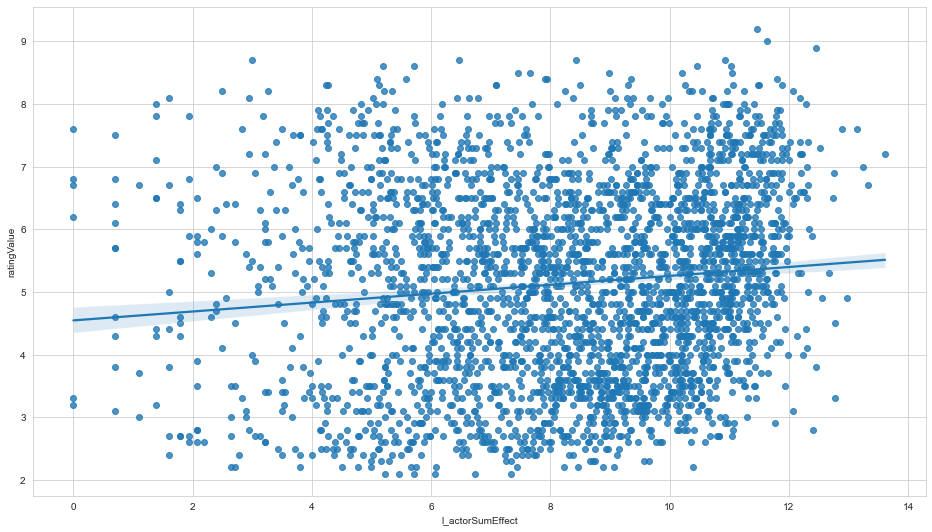

In [61]:
sns.regplot(x=X.l_actorSumEffect, y=y)
# ok so obviously this is a complete mess.

<AxesSubplot:xlabel='l_writerSumEffect', ylabel='ratingValue'>

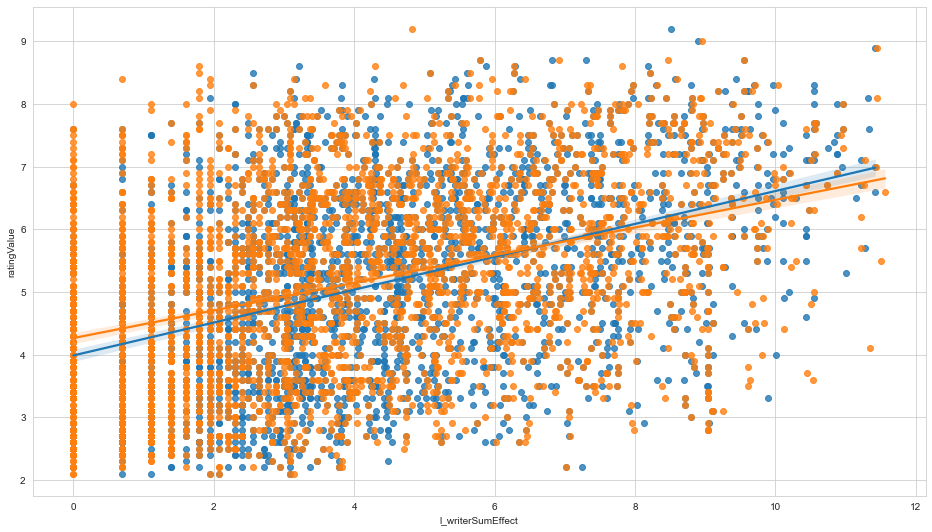

In [62]:
sns.regplot(x=X.l_directorSumEffect, y=y)
sns.regplot(x=X.l_writerSumEffect, y=y)
# effect for directors and writers is more obviously positive
# also observe: many directors and writers with 0 fans!

## Heteroscedasticity?

In [35]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html#Heteroskedasticity-tests
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(name, test)
# obviously highly heteroscedastistic

[('Lagrange multiplier statistic', 136.87625968722142),
 ('p-value', 8.349662156316247e-13),
 ('f-value', 3.6285657764569503),
 ('f p-value', 3.6910502207359305e-13)]

## With Max Effects

In [64]:
X = movies.iloc[:,8:]
X.drop(columns=["directorSumEffect", "actorSumEffect", "writerSumEffect"], inplace=True)
X.insert(0, "intercept", 1)
X.head()

,intercept,directorMaxEffect,actorMaxEffect,writerMaxEffect,d动画,d悬疑,d剧情,d西部,d犯罪,d灾难,...,y2013,y2014,y2015,y2016,y2017,y2018,y2019,y2020,y2021,y2022
0,1,34235,27592,5441,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,65,3861,65,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,43,43,43,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,115,161,115,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2,192,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
mod = sm.OLS(y, X)
res = mod.fit(cov_type='hc3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            ratingValue   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     34.49
Date:                Fri, 01 Jul 2022   Prob (F-statistic):          1.57e-208
Time:                        13:13:27   Log-Likelihood:                -4998.6
No. Observations:                2996   AIC:                         1.008e+04
Df Residuals:                    2956   BIC:                         1.032e+04
Df Model:                          39                                         
Covariance Type:                  hc3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             5.4140      0.11

In [66]:
log_columns(X, ["directorMaxEffect", "actorMaxEffect", "writerMaxEffect"])

In [67]:
mod = sm.OLS(y, X)
res = mod.fit(cov_type='hc3')
print(res.summary())
# qualitatively, no difference with sum effects

                            OLS Regression Results                            
Dep. Variable:            ratingValue   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     65.49
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        13:13:31   Log-Likelihood:                -4746.1
No. Observations:                2996   AIC:                             9572.
Df Residuals:                    2956   BIC:                             9812.
Df Model:                          39                                         
Covariance Type:                  hc3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept               4.7386    

In [78]:
movies.to_csv("./data/movies_reg_df.csv")